In [1]:
#utils
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

#Keras
import keras
from keras import losses, Sequential, layers
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.applications import EfficientNetB0
from keras.utils import image_dataset_from_directory


import tensorflow as tf
tf.test.is_built_with_cuda()
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
img_size = 224
batch_size = 32
epochs = 100
input_shape = (img_size, img_size, 3)

img_path = os.getcwd() + '\\dataset\\'
print({img_path})
print(os.getcwd() + "\\mosiqueto\\data_splitting\\Test\\")

{'d:\\project linear\\dataset\\'}
d:\project linear\mosiqueto\data_splitting\Test\


In [ ]:
import albumentations as A
import cv2
import os
import shutil
from sklearn.model_selection import train_test_split

# Declare an augmentation pipeline
transformations = A.Compose([
    A.RandomRotate90(p=0.1),  
    A.HorizontalFlip(p=0.2),  
    A.VerticalFlip(p=0.1),    
    A.RandomScale(p=0.3),     
    A.SafeRotate(p=0.4),      
    A.GridDistortion(p=0.2),  
])
# Read images from the source directory
source_dir = "mosquito"
output_dir = "augmented_data"

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Lists to hold file paths for each class
class_paths = []

# Iterate through each subdirectory in the source directory
for sub_dir in os.listdir(source_dir):
    sub_dir_path = os.path.join(source_dir, sub_dir)

    if os.path.isdir(sub_dir_path):
        # Create a subdirectory in the output directory
        output_sub_dir = os.path.join(output_dir, sub_dir)
        os.makedirs(output_sub_dir, exist_ok=True)

        # Augment and copy images to the output directory
        image_files = os.listdir(sub_dir_path)
        for image_file in image_files:
            image_path = os.path.join(sub_dir_path, image_file)
            image = cv2.imread(image_path)
            augmented_images = [transformations(image=image)['image'] for _ in range(10)]

            for i, augmented_image in enumerate(augmented_images):
                output_image_path = os.path.join(output_sub_dir, f"{i}_{image_file}")
                cv2.imwrite(output_image_path, augmented_image)

                # Store paths to augmented images in the class_paths list
                class_paths.append(output_image_path)

# Split the data into train, test, and validation sets
train_size = 0.7
test_size = 0.2
val_size = 0.1

train_paths, test_val_paths = train_test_split(class_paths, test_size=test_size + val_size, random_state=42)
test_paths, val_paths = train_test_split(test_val_paths, test_size=val_size / (test_size + val_size), random_state=42)

# Move the split data to appropriate directories (e.g., train, test, val)
for split, split_paths in [("Train", train_paths), ("Test", test_paths), ("Pred", val_paths)]:
    for path in split_paths:
        class_dir = os.path.basename(os.path.dirname(path))
        target_dir = os.path.join("augmented_split_data", split, class_dir)
        os.makedirs(target_dir, exist_ok=True)
        target_path = os.path.join(target_dir, os.path.basename(path))
        shutil.copy(path, target_path)

print("Data splitting and augmentation completed.")

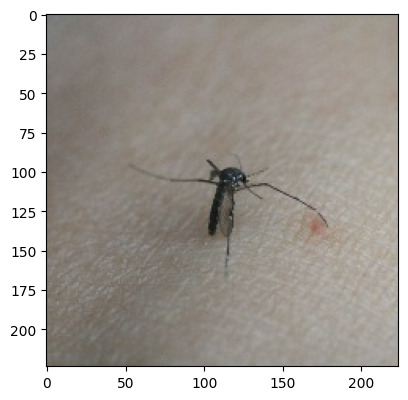

In [5]:


plt.figure(figsize=(10, 10))

img = cv2.imread(r"D:\project linear\mosquito\Aedes  albopictus landing\9.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (img_size, img_size))
plt.subplot(1, 2, 1)
plt.imshow(img)

In [4]:
base_path = os.getcwd() + "\\augmented_split_data\\"
train_set = image_dataset_from_directory(
    base_path + "Train\\", 
    image_size=(img_size, img_size), 
    shuffle=True,
    label_mode='categorical', 
    batch_size=batch_size,
    subset="training",
    validation_split=0.3,
    seed=42
) 

test_set = image_dataset_from_directory(
    base_path + "Test\\",
    image_size=(img_size, img_size),
    shuffle=False, 
    label_mode='categorical',
    batch_size=batch_size,
    seed=42
)

val_set = image_dataset_from_directory(
    base_path + "Train\\",
    image_size=(img_size, img_size),
    label_mode='categorical',
    shuffle=True, 
    batch_size=batch_size,
    subset="validation",
    validation_split=0.3,
    seed=42
)

train_set.class_names
test_set.class_names
val_set.class_names

Found 10499 files belonging to 6 classes.
Using 7350 files for training.
Found 3000 files belonging to 6 classes.
Found 10499 files belonging to 6 classes.
Using 3149 files for validation.


['Aedes  albopictus landing',
 'Aedes aegypti landing',
 'Aedes aegypti smashed',
 'Aedes albopictus smashed',
 'Culex quinquefasciatus landing',
 'Culex quinquefasciatus smashed']

data batch shape: (32, 224, 224, 3)
label batch shape: (32, 6)


<Figure size 5000x5000 with 0 Axes>

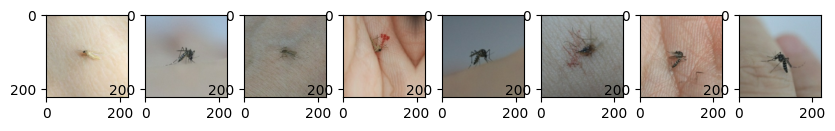

In [5]:
plt.figure(figsize=(50, 50))
for data_batch, label_batch in train_set:
    print('data batch shape:', data_batch.shape)
    print('label batch shape:', label_batch.shape)
    
    fig, axes = plt.subplots(1, 8, figsize=(10,5))
    for i, ax in enumerate(axes):
        ax.imshow(np.array(data_batch[i])/255)
    break

plt.show()

In [6]:
base_model = EfficientNetB0(
  weights='imagenet',
  include_top=False, 
  input_shape=input_shape
)

base_model.trainable = False
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0

In [ ]:
for i, layer in enumerate(base_model.layers):
  print(i, layer.name)

In [7]:
def create_model():
    
    result = base_model.output
    
    drop = Dropout(0.5)(result)
    
    avg_result = GlobalAveragePooling2D()(drop)
    fully_connect = Dense(1280, activation='relu')(avg_result)
    fully_connect = Dense(1280, activation='relu')(fully_connect)
    fully_connect = Dense(640, activation='relu')(fully_connect)
    prediction = Dense(6, activation='softmax')(fully_connect)

    model = Model(inputs=base_model.input, outputs=prediction)
    model.summary()
    return model

In [8]:
model = create_model()
for layer in model.layers[238:]:
    layer.trainable = True

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0]']      

In [9]:
train_ds = train_set.prefetch(tf.data.AUTOTUNE)
val_ds = val_set.prefetch(tf.data.AUTOTUNE)


In [16]:
model.compile(
    loss=losses.CategoricalCrossentropy(),
    optimizer=Adam(learning_rate=1e-5),
    metrics=["accuracy"]
    )

In [11]:
device = tf.config.get_visible_devices()
print(device)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# from pathlib import Path
# import filetype


# # RFC image file extensions supported by TensorFlow
# img_exts = {"png", "jpg", "gif", "bmp"}

# path = Path(img_path)

# for dir in path.iterdir():
#     print(dir)
#     for file in dir.iterdir():
#         if file.is_dir():
#             continue
        
#         ext = filetype.guess_extension(file)
    
#         if ext is None:
#             print(f"'{file}': extension cannot be guessed from content")
#             os.remove(file)
#         elif ext not in img_exts:
#             print(f"'{file}': not a supported image file")
#             os.remove(file)


In [17]:
callback = [
    keras.callbacks.ModelCheckpoint("checkpoints/model_11_checkpoint/save_at_{epoch}.keras"),
    keras.callbacks.EarlyStopping(
            monitor="val_loss", 
            patience=10
    ),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)
]

history = model.fit(
    train_ds,
    epochs=epochs,
    verbose=1,
    callbacks=callback,
    validation_data=val_ds,
    shuffle=True
)

Epoch 1/100


230/230 [==============================] - 31s 118ms/step - loss: 1.4970 - accuracy: 0.5161 - val_loss: 1.1216 - val_accuracy: 0.6716 - lr: 1.0000e-05
Epoch 2/100
230/230 [==============================] - 25s 107ms/step - loss: 0.9556 - accuracy: 0.6985 - val_loss: 0.7174 - val_accuracy: 0.7650 - lr: 1.0000e-05
Epoch 3/100
230/230 [==============================] - 25s 107ms/step - loss: 0.7035 - accuracy: 0.7616 - val_loss: 0.5655 - val_accuracy: 0.8069 - lr: 1.0000e-05
Epoch 4/100
230/230 [==============================] - 26s 112ms/step - loss: 0.5902 - accuracy: 0.7966 - val_loss: 0.4893 - val_accuracy: 0.8320 - lr: 1.0000e-05
Epoch 5/100
230/230 [==============================] - 25s 108ms/step - loss: 0.5151 - accuracy: 0.8252 - val_loss: 0.4223 - val_accuracy: 0.8615 - lr: 1.0000e-05
Epoch 6/100
230/230 [==============================] - 24s 106ms/step - loss: 0.4707 - accuracy: 0.8382 - val_loss: 0.3825 - val_accuracy: 0.8717 - lr: 1.0000e-05
Epoch 7/100
230/230 [=============

In [18]:
scores = model.evaluate(test_set, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


94/94 [==============================] - 8s 84ms/step - loss: 0.0507 - accuracy: 0.9830
Test loss: 0.0507054440677166
Test accuracy: 0.9829999804496765


In [19]:
model.save('./trained_model_11/')

INFO:tensorflow:Assets written to: ./trained_model_11/assets


INFO:tensorflow:Assets written to: ./trained_model_11/assets


In [3]:
# print(img.shape)
loaded_model = tf.keras.models.load_model('./trained_model_10/')

In [ ]:
scores = loaded_model.evaluate(test_set, verbose=1)
print('Test loss:', scores[0])  
print('Test accuracy:', scores[1])


D:\project linear\data_splitting\Pred\aegypti smashed\416.jpg
1/1 [==============================] - 0s 20ms/step
[1.1049650e-03 2.9228655e-01 7.0602602e-01 3.0380179e-04 1.1415329e-06
 2.7755529e-04] 

pred: Aedes aegypti smashed
Aedes  albopictus landing 0.11049649911001325%
Aedes aegypti landing 29.228654503822327%
Aedes aegypti smashed 70.6026017665863%
Aedes albopictus smashed 0.03038017894141376%
Culex quinquefasciatus landing 0.00011415329481678782%
Culex quinquefasciatus smashed 0.027755528572015464%


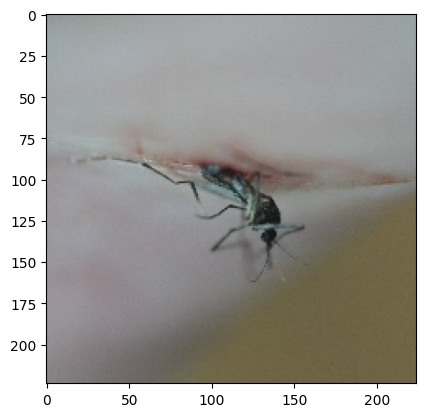

In [59]:
import os, random
def pred():
    target = "D:\\project linear\\data_splitting\\Pred\\"
    while True:
        try:
            pred_path = random.choice(os.listdir(target))
            break
        except:
            continue

    pred_path = target + pred_path +"\\"
    while True:
        try:
            pred_img = random.choice(os.listdir(pred_path))
            break
        except:
            continue

    pred_img = pred_path + pred_img
    # pred_img = r"D:\project linear\Galaxy-A52s_Cx-quinquefasciatus_s01_l2_t1_A9.png"
    img_pred = cv2.imread(pred_img)
    img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)
    img_pred = cv2.resize(img_pred, (img_size, img_size))
    img_pred = np.expand_dims(img_pred, axis=0)
    print(pred_img)
    plt.imshow(img_pred[0])

    result = model.predict(img_pred)[0]
    _classes = result.argmax(axis=-1)
    pred_class = test_set.class_names[_classes]
    print(result, "\n")
    print(f"pred: {pred_class}")
    for i in range(len(test_set.class_names)):
        print(test_set.class_names[i], f"{result[i]*100}%")
pred()

In [3]:
import cv2
import matplotlib.pyplot as plt

# Define the image path and the number of augmentations to display
temp = "augmented_data/Aedes aegypti landing/0_0.jpg"
num_augmentations = 10

# Load the image
image = cv2.imread(temp)
image = cv2.resize(image, (img_size, img_size))

# Create a figure for displaying augmented images
plt.figure(figsize=(100, 100))

# Loop to display augmented images
for i in range(num_augmentations):
        plt.subplot(4, 3, i+1)
        augmented_image = cv2.imread(f"augmented_data/Aedes aegypti landing/{i}_0.jpg")
        augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB)
        augmented_image = cv2.resize(augmented_image, (img_size, img_size))
        plt.imshow(augmented_image)

# Show the plot
plt.show()

In [16]:
import numpy as np

array1 = np.array([1, 3, 5, 7, 2, 4, 6, 8])
print("array1 shape : ", array1.shape)

result = np.reshape(array1, (1, 1, len(array1)))
print("result shape : ", result.shape)
print("result : ", result)

array1 shape :  (8,)
result shape :  (1, 1, 8)
result :  [[[1 3 5 7 2 4 6 8]]]
